In [1]:
# SISO 5G gNB-UE Simulation using AIRSTRAN D 2200

# Import or install Sionna
try:
    import sionna.rt
except ImportError as e:
    import os
    os.system("pip install sionna-rt")
    import sionna.rt

# Other imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import mitsuba as mi
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", message="invalid value encountered in multiply")
warnings.filterwarnings("ignore", category=UserWarning, module="jupyter_client")

# Import relevant components from Sionna RT
from sionna.rt import load_scene, Transmitter, Receiver, Transmitter, Camera, PathSolver
from sionna.rt import AntennaArray, PlanarArray, SceneObject, ITURadioMaterial
from sionna.rt.antenna_pattern import antenna_pattern_registry

# Load empty scene
scene = load_scene("/home/tingjunlab/Development/geo2sigmap/scenes/Duke_Perkins/scene.xml")

jit_find_library(): Unable to load "/usr/lib/x86_64-linux-gnu/libLLVM-20.so": /home/tingjunlab/anaconda3/lib/python3.13/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /usr/lib/x86_64-linux-gnu/libLLVM-20.so)!
jitc_llvm_init(): LLVM API initialization failed ..


2025-12-16 16:36:13 WARN  [HDRFilm] Monochrome mode enabled, setting film output pixel format to 'luminance' (was rgb).


In [2]:
import sys
import os

# Add the src directory to the Python path
sys.path.append(os.path.abspath('../src'))

In [3]:
# Install plyfile if not available
try:
    from plyfile import PlyData
except ImportError:
    import os
    os.system("pip install plyfile")
    from plyfile import PlyData

In [4]:
# ============================================
# SISO Configuration: gNB to UE
# ============================================

# Set the operating frequency (n48 band for 5G)
scene.frequency = 3.7e9  # 3.7 GHz

# Define UE position (fixed to start)
ue_position = [10.0, 0.0, 0.0]   # UE position (x, y, z in meters)

# ============================================
# Antenna Configuration
# ============================================

# gNB antenna: 3GPP TR 38.901 pattern (AIRSTRAN D 2200)
gnb_pattern_factory = antenna_pattern_registry.get("tr38901")
gnb_pattern = gnb_pattern_factory(polarization="V")

# UE antenna: Isotropic pattern (typical for mobile devices)
ue_pattern_factory = antenna_pattern_registry.get("iso")
ue_pattern = ue_pattern_factory(polarization="V")

# SISO: Single antenna element at origin [0, 0, 0] for both TX and RX
single_element = np.array([[0.0, 0.0, 0.0]])  # Shape: (1, 3)

# Configure antenna arrays
scene.tx_array = AntennaArray(
    antenna_pattern=gnb_pattern,
    normalized_positions=single_element.T  # Shape: (3, 1)
)

scene.rx_array = AntennaArray(
    antenna_pattern=ue_pattern,
    normalized_positions=single_element.T  # Shape: (3, 1)
)

# ============================================
# Add Receiver to Scene
# ============================================

# Create UE receiver
rx = Receiver(name="ue", position=ue_position, display_radius=0.03)
scene.add(rx)

# ============================================
# Configure Propagation Environment
# ============================================

# Disable scattering for basic simulation
for radio_material in scene.radio_materials.values():
    radio_material.scattering_coefficient = 0.0

In [5]:
from scene_parser import extract_building_info
from tx_placement import TxPlacement

In [6]:
# ============================================
# Place gNB on a Specific Building
# ============================================

scene_xml_path = "/home/tingjunlab/Development/geo2sigmap/scenes/Duke_Perkins/scene.xml"
building_info = extract_building_info(scene_xml_path, verbose=True)

selected_building_id = 5  # Change this to your desired building number

# TxPlacement will create the transmitter if it doesn't exist and place it on the building
# Correct parameter order: (scene, tx_name, scene_xml_path, building_id, offset)
tx_placer = TxPlacement(scene, "gnb", scene_xml_path, selected_building_id, offset=5.0)
tx_placer.set_rooftop_center()

# Get reference to the transmitter (already added to scene by TxPlacement)
tx = tx_placer.tx
# Convert to flat numpy array instead of nested list
gnb_position = tx.position.numpy().flatten().tolist()

# Point antenna toward UE
tx.look_at(ue_position)

print(f"\nSuccess! gNB placed on building {selected_building_id}")
print(f"Position: {gnb_position}")

# ============================================
# Compute Propagation Paths
# ============================================

# Instantiate path solver
p_solver = PathSolver()

# Compute propagation paths
paths = p_solver(
    scene=scene,
    max_depth=5,
    los=True,
    specular_reflection=True,
    diffuse_reflection=False,
    diffraction=True,
    edge_diffraction=True,
    refraction=False,
    seed=41
)

# ============================================
# Visualize Scene
# ============================================

# Setup camera
cam = Camera(position=(100.0, 100.0, 50.0))
cam.look_at(gnb_position)

# Preview the scene with propagation paths
scene.preview(
    paths=paths,
    resolution=[1000, 1000],
    clip_at=50,
    show_orientations=True
)

Available buildings in scene: 50 total

Building 0:
  Rooftop height: 14.00 m
  X range: [-216.99, -156.26] m (center: -186.63)
  Y range: [190.97, 255.05] m (center: 223.01)
  Vertices: 17

Building 1:
  Rooftop height: 7.00 m
  X range: [-178.25, -101.96] m (center: -140.10)
  Y range: [-305.26, -198.70] m (center: -251.98)
  Vertices: 10

Building 2:
  Rooftop height: 14.00 m
  X range: [87.04, 121.35] m (center: 104.20)
  Y range: [-62.49, -17.73] m (center: -40.11)
  Vertices: 22

Building 3:
  Rooftop height: 10.50 m
  X range: [-15.64, 74.27] m (center: 29.32)
  Y range: [195.85, 255.17] m (center: 225.51)
  Vertices: 27

Building 4:
  Rooftop height: 17.50 m
  X range: [-112.96, -88.45] m (center: -100.71)
  Y range: [-44.59, -17.83] m (center: -31.21)
  Vertices: 6

Building 5:
  Rooftop height: 10.50 m
  X range: [17.20, 97.46] m (center: 57.33)
  Y range: [-4.34, 46.70] m (center: 21.18)
  Vertices: 12

Building 6:
  Rooftop height: 17.50 m
  X range: [104.77, 131.33] m (cen

ZONE MASK CREATED
Zone type: Angular sector (0° to 120°, radius 100m)
Zone contains 34796 grid cells
Zone coverage: 13.9% of map
Naive baseline look-at: [-10.329161643981934, -193.4045867919922, 0.0]
Zone centroid: [-12.806605797611173, -144.3480954732232]



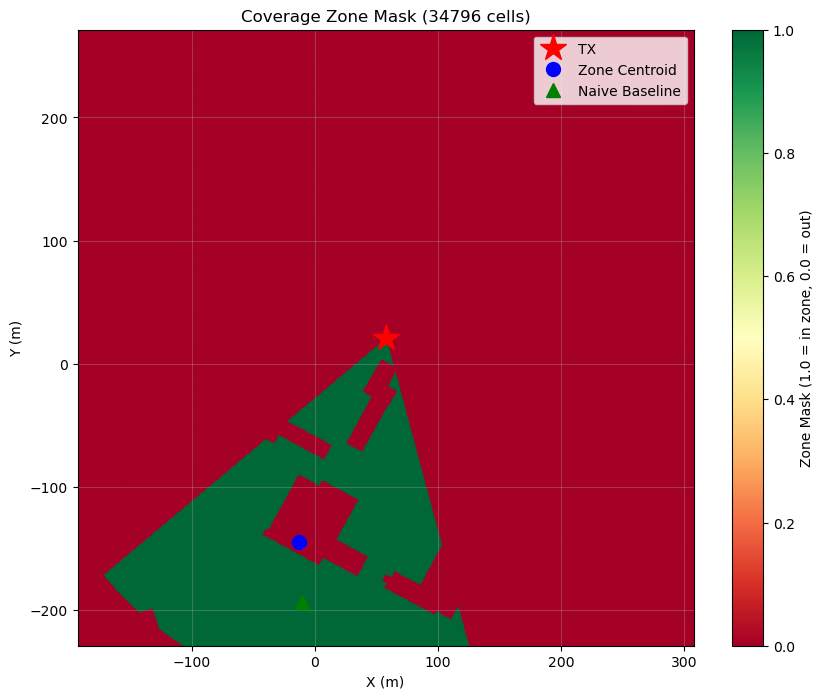

STARTING BINARY MASK OPTIMIZATION

Binary Mask Zone Coverage Optimization
Initial boresight: (-10.3, -193.4, 0.0)
Use grid search init: True
Learning rate: 20.0
Iterations: 100
Sample points: 40
Loss type: coverage_threshold
Power threshold: -70.0 dB
Map config: {'center': [57.32964324951172, 21.18172264099121, 0], 'size': [500, 500], 'cell_size': (1, 1), 'ground_height': 0.0}


PHASE 1: Grid Search for Initial Boresight


Grid Search for Initial Boresight
TX position: (57.3, 21.2, 15.5)
Angular samples: 20
Elevation samples: 6
Total directions to test: 120

[1/120] NEW BEST: Az=0°, El=0° → -147.8 dB
[2/120] NEW BEST: Az=0°, El=-9° → -147.8 dB
[5/120] Az=0°, El=-36° → -149.1 dB
[10/120] Az=18°, El=-27° → -150.2 dB
[15/120] Az=36°, El=-18° → -151.2 dB
[20/120] Az=54°, El=-9° → -151.5 dB
[25/120] Az=72°, El=0° → -150.7 dB
[30/120] Az=72°, El=-45° → -151.9 dB
[35/120] Az=90°, El=-36° → -150.1 dB
[37/120] NEW BEST: Az=108°, El=0° → -146.0 dB
[38/120] NEW BEST: Az=108°, El=-9° → -145.9 dB
[

In [ ]:
from boresight_pathsolver import (
    optimize_boresight_pathsolver,
    create_zone_mask
)
import matplotlib.pyplot as plt

# ============================================
# NEW BINARY MASK APPROACH
# ============================================
# Instead of creating a target radiomap with specific power levels,
# we create a BINARY MASK that defines the coverage zone.
# The optimizer will maximize coverage within this zone.

# Map configuration
map_config = {
    'center': [gnb_position[0], gnb_position[1], 0],
    'size': [500, 500],
    'cell_size': (1, 1),
    'ground_height': 0.0,
}

# ============================================
# OPTION 1: Angular Sector Zone (RECOMMENDED)
# ============================================
# Create a wedge-shaped sector pointing from the TX
zone_mask, naive_look_at, zone_stats = create_zone_mask(
    map_config=map_config,
    zone_type='angular_sector',
    origin_point=gnb_position,
    zone_params={
        'angle_start': 220,
        'angle_end': 220+65,      # Try 65° to match TR38.901 beamwidth
        'radius': 300         # Larger radius
    },
    target_height=0.0,
    scene_xml_path="/home/tingjunlab/Development/geo2sigmap/scenes/Duke_Perkins/scene.xml",
    exclude_buildings=True           # ← This is True by default
)

#map_config = {
#    'center': [gnb_position[0], gnb_position[1], 0],
#    'size': [500, 500],
#    'cell_size': (1, 1),
#    'ground_height': 0.0,
#}

#zone_params = {
#    'center': (110, -110),
#    'width': 100,
#    'height': 100
#}

#zone_mask, naive_look_at, zone_stats = create_zone_mask(
#    map_config=map_config,
#    zone_type='box',
#    zone_params=zone_params,
#    target_height=1.5,
#    scene_xml_path=scene_xml_path,
#    exclude_buildings=True
#)

print("=" * 70)
print("ZONE MASK CREATED")
print("=" * 70)
print(f"Zone type: Angular sector (0° to 120°, radius 100m)")
print(f"Zone contains {zone_stats['num_cells']} grid cells")
print(f"Zone coverage: {zone_stats['coverage_fraction']*100:.1f}% of map")
print(f"Naive baseline look-at: {zone_stats['look_at_xyz']}")
print(f"Zone centroid: {zone_stats['centroid_xy']}")
print()

# ============================================
# OPTION 2: Box Zone (Alternative)
# ============================================
# Uncomment to use a rectangular zone instead:
"""
zone_mask, naive_look_at, zone_stats = create_zone_mask(
    map_config=map_config,
    zone_type='box',
    zone_params={
        'center': (gnb_position[0] + 50, gnb_position[1] + 50),
        'width': 80,   # 80m wide
        'height': 60   # 60m tall
    },
    target_height=1.5
)
"""

# ============================================
# Visualize the Zone Mask
# ============================================
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(
    zone_mask,
    origin='lower',
    cmap='RdYlGn',
    extent=[
        map_config['center'][0] - map_config['size'][0]/2,
        map_config['center'][0] + map_config['size'][0]/2,
        map_config['center'][1] - map_config['size'][1]/2,
        map_config['center'][1] + map_config['size'][1]/2,
    ],
    vmin=0,
    vmax=1
)
plt.colorbar(im, ax=ax, label='Zone Mask (1.0 = in zone, 0.0 = out)')
ax.plot(gnb_position[0], gnb_position[1], 'r*', markersize=20, label='TX')
ax.plot(zone_stats['centroid_xy'][0], zone_stats['centroid_xy'][1], 'bo',
        markersize=10, label='Zone Centroid')
ax.plot(zone_stats['look_at_xyz'][0], zone_stats['look_at_xyz'][1], 'g^',
        markersize=10, label='Naive Baseline')
ax.set_title(f'Coverage Zone Mask ({zone_stats["num_cells"]} cells)')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

# ============================================
# Run Optimization with Binary Mask
# ============================================
print("=" * 70)
print("STARTING BINARY MASK OPTIMIZATION")
print("=" * 70)

best_boresight, loss_hist, bore_hist, grad_hist, cov_stats = optimize_boresight_pathsolver(
    scene=scene,
    tx_name="gnb",
    map_config=map_config,
    scene_xml_path=scene_xml_path,
    zone_mask=zone_mask, 
    initial_boresight=naive_look_at.tolist(),  # Use zone center as starting point
    num_sample_points=50,
    learning_rate=18.0,
    num_iterations=100,
    loss_type='coverage_threshold', 
    use_grid_search_init=True,
    grid_search_params={
        'num_angular_samples': 20,  # Finer grid = better init
        'num_elevation_samples': 6,  # More elevation angles
        'num_sample_points': 100,   # Fast grid search
    },
    # Alternative loss types:
    power_threshold_dbm=-75,
    # loss_type='percentile_maximize'
    verbose=True,
    seed=42,
    # Enable frame saving
    save_radiomap_frames=False,  # Set to True to save frames
    frame_save_interval=10,
    output_dir="/home/tingjunlab/Development/optimize_tx/optimization_gif"
)

print(f"\nOptimization complete!")
print(f"Final coverage stats: {cov_stats}")

Computing RadioMap for Naive Baseline...
Computing RadioMap for Optimized...

COMPARISON SUMMARY
Naive Baseline Mean:  -60.83 dB
Optimized Mean:       -59.67 dB
Improvement:          +1.16 dB (1.9%)



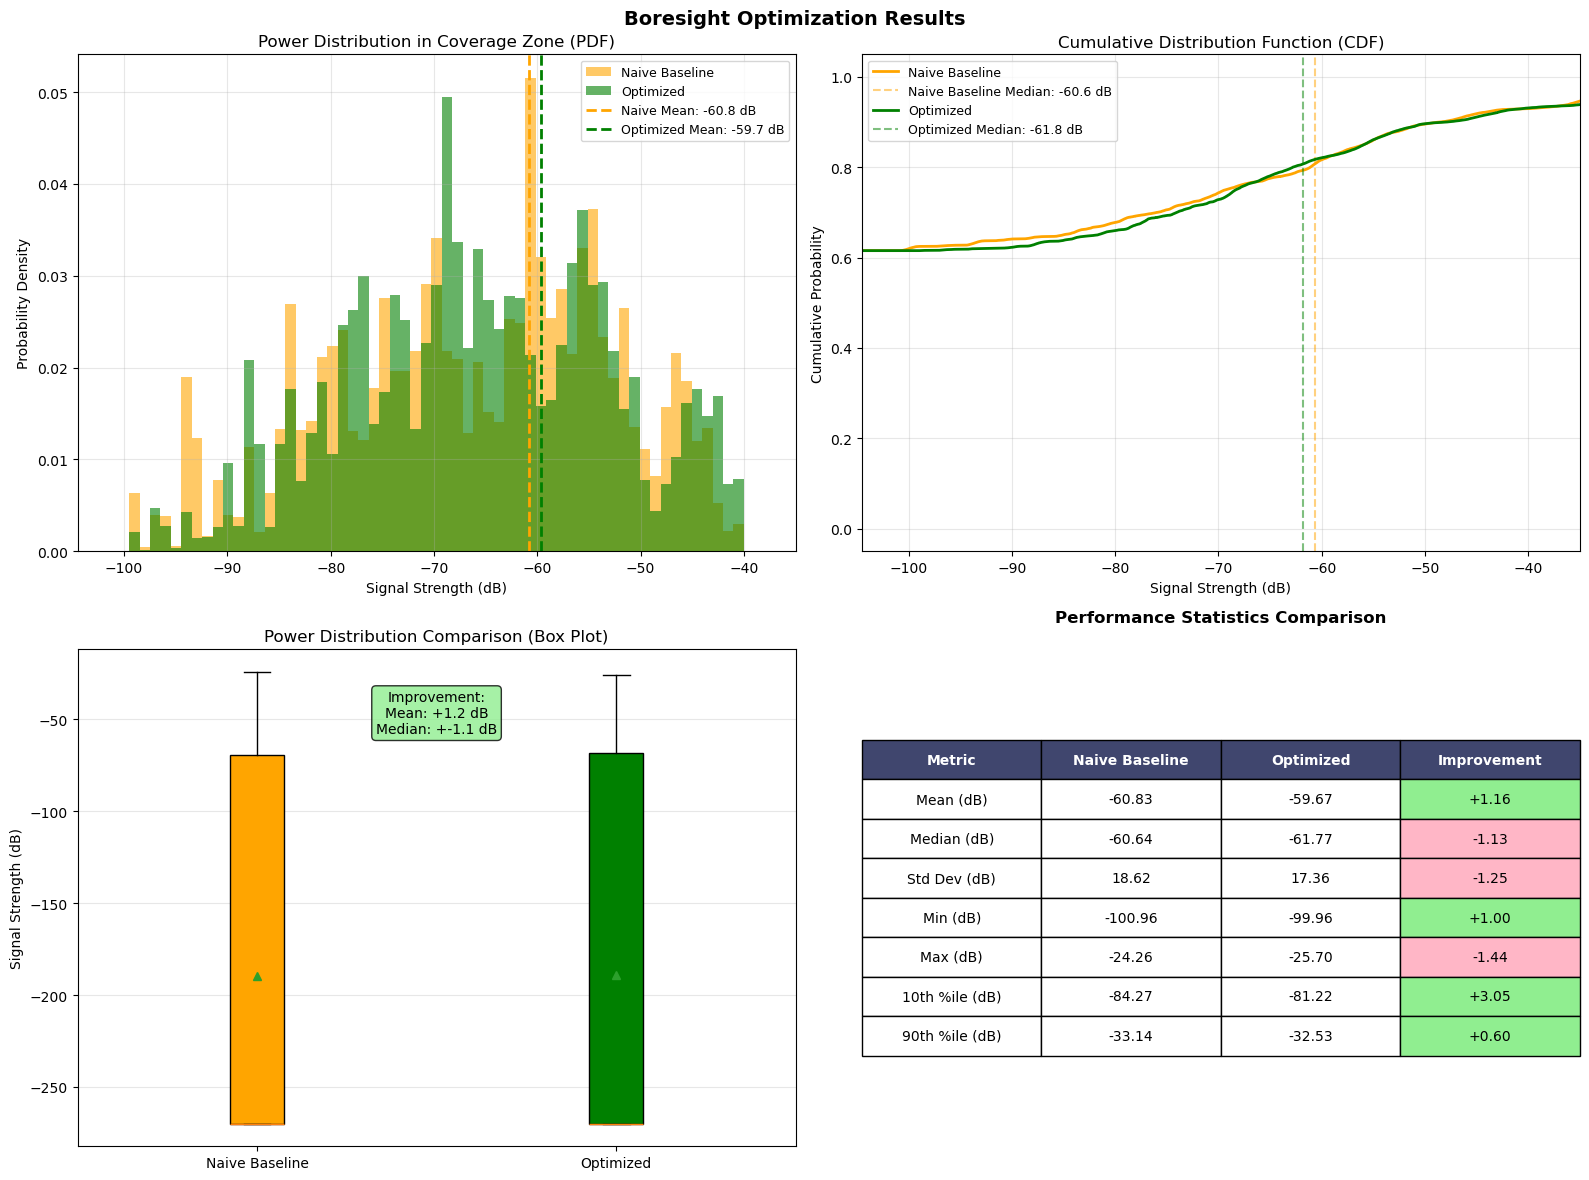

Mean improvement: 1.16 dB
Median improvement: -1.13 dB
Percentage improvement: 1.9%


In [8]:
from boresight_pathsolver import compare_boresight_performance

# After optimization is complete, compare results
fig, comparison_stats = compare_boresight_performance(
    scene=scene,
    tx_name="gnb",
    map_config=map_config,
    zone_mask=zone_mask,
    naive_boresight=naive_look_at,  # From create_zone_mask
    optimized_boresight=best_boresight,  # From optimize_boresight_pathsolver
    title="Boresight Optimization Results"
)

plt.show()

# Print detailed stats
print(f"Mean improvement: {comparison_stats['improvement_mean_dB']:.2f} dB")
print(f"Median improvement: {comparison_stats['improvement_median_dB']:.2f} dB")
print(f"Percentage improvement: {comparison_stats['improvement_percent']:.1f}%")

RADIO MAP VISUALIZATION (OPTIMIZED)
Optimized boresight: (-47.7, -73.4, 2.8)
TX location: [[57.3296, 21.1817, 15.5]]
Coverage zone: 40/40 samples
Final loss: 48.2450

Coverage Analysis:
  Mean power in zone: -68.70 dBm
  Median power in zone: -64.84 dBm
  Min power in zone: -270.00 dBm
  Max power in zone: -25.78 dBm
  Std dev in zone: 33.87 dB

  Above -90 dBm: 33315/34796 (95.7%)
  Above -85 dBm: 32670/34796 (93.9%)
  Above -80 dBm: 31670/34796 (91.0%)
  Above -75 dBm: 30260/34796 (87.0%)
  Above -70 dBm: 25310/34796 (72.7%)



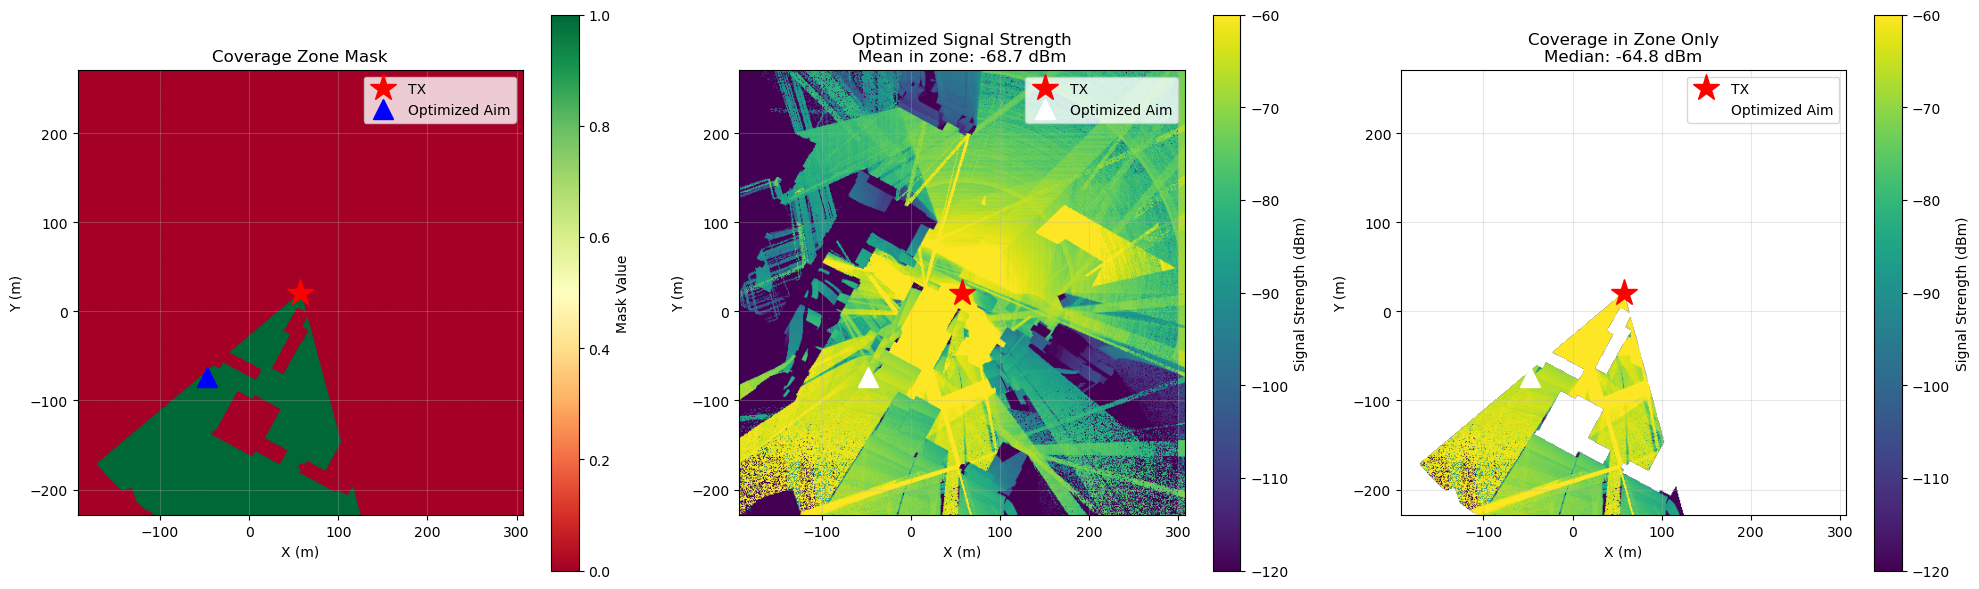

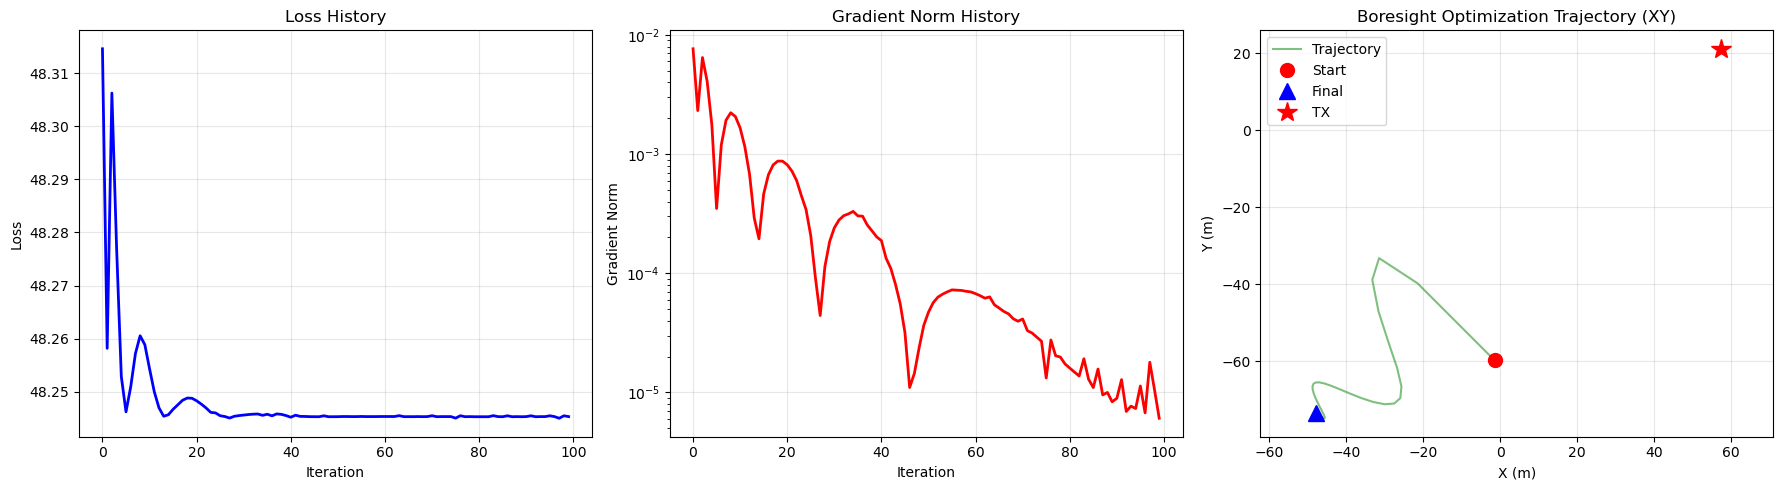

In [9]:
from sionna.rt import RadioMapSolver
import matplotlib.pyplot as plt

# Apply the optimized boresight
tx.look_at(mi.Point3f(float(best_boresight[0]), float(best_boresight[1]), float(best_boresight[2])))

print("=" * 70)
print("RADIO MAP VISUALIZATION (OPTIMIZED)")
print("=" * 70)
print(f"Optimized boresight: ({best_boresight[0]:.1f}, {best_boresight[1]:.1f}, {best_boresight[2]:.1f})")
print(f"TX location: {tx.position}")
print(f"Coverage zone: {cov_stats['num_samples_in_zone']}/{cov_stats['num_samples_total']} samples")
print(f"Final loss: {cov_stats['final_loss']:.4f}")
print()

# Generate radio map matching the optimization configuration
rm_solver = RadioMapSolver()
rm = rm_solver(
    scene,
    max_depth=5,
    samples_per_tx=int(6e8),
    cell_size=map_config['cell_size'],
    center=map_config['center'],
    orientation=[0, 0, 0],
    size=map_config['size'],
    los=True,
    specular_reflection=True,
    diffuse_reflection=True,
    diffraction=True,
    edge_diffraction=True,
    refraction=False,
    stop_threshold=None,
)

# Extract signal levels
rss_watts = rm.rss.numpy()[0, :, :]
signal_strength_dBm = 10.0 * np.log10(rss_watts + 1e-30) + 30.0

# ============================================
# Analyze Coverage in the Zone
# ============================================
# Extract power values only in the zone
zone_power = signal_strength_dBm[zone_mask == 1.0]

print("Coverage Analysis:")
print(f"  Mean power in zone: {np.mean(zone_power):.2f} dBm")
print(f"  Median power in zone: {np.median(zone_power):.2f} dBm")
print(f"  Min power in zone: {np.min(zone_power):.2f} dBm")
print(f"  Max power in zone: {np.max(zone_power):.2f} dBm")
print(f"  Std dev in zone: {np.std(zone_power):.2f} dB")
print()

# Count cells above various thresholds
thresholds = [-90, -85, -80, -75, -70]
for thresh in thresholds:
    above = np.sum(zone_power > thresh)
    pct = 100.0 * above / len(zone_power)
    print(f"  Above {thresh} dBm: {above}/{len(zone_power)} ({pct:.1f}%)")
print()

# ============================================
# Visualize Results
# ============================================
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

extent = [
    map_config['center'][0] - map_config['size'][0]/2,
    map_config['center'][0] + map_config['size'][0]/2,
    map_config['center'][1] - map_config['size'][1]/2,
    map_config['center'][1] + map_config['size'][1]/2,
]

# Plot 1: Zone Mask
im1 = axes[0].imshow(zone_mask, origin='lower', cmap='RdYlGn', extent=extent, vmin=0, vmax=1)
axes[0].plot(gnb_position[0], gnb_position[1], 'r*', markersize=20, label='TX')
axes[0].plot(best_boresight[0], best_boresight[1], 'b^', markersize=15, label='Optimized Aim')
axes[0].set_title('Coverage Zone Mask')
axes[0].set_xlabel('X (m)')
axes[0].set_ylabel('Y (m)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
plt.colorbar(im1, ax=axes[0], label='Mask Value')

# Plot 2: RadioMap (Signal Strength)
im2 = axes[1].imshow(signal_strength_dBm, origin='lower', cmap='viridis', 
                     extent=extent, vmin=-120, vmax=-60)
axes[1].plot(gnb_position[0], gnb_position[1], 'r*', markersize=20, label='TX')
axes[1].plot(best_boresight[0], best_boresight[1], 'w^', markersize=15, label='Optimized Aim')
axes[1].set_title(f'Optimized Signal Strength\nMean in zone: {np.mean(zone_power):.1f} dBm')
axes[1].set_xlabel('X (m)')
axes[1].set_ylabel('Y (m)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.colorbar(im2, ax=axes[1], label='Signal Strength (dBm)')

# Plot 3: Masked Coverage (only show zone)
masked_signal = np.where(zone_mask == 1.0, signal_strength_dBm, np.nan)
im3 = axes[2].imshow(masked_signal, origin='lower', cmap='viridis',
                     extent=extent, vmin=-120, vmax=-60)
axes[2].plot(gnb_position[0], gnb_position[1], 'r*', markersize=20, label='TX')
axes[2].plot(best_boresight[0], best_boresight[1], 'w^', markersize=15, label='Optimized Aim')
axes[2].set_title(f'Coverage in Zone Only\nMedian: {np.median(zone_power):.1f} dBm')
axes[2].set_xlabel('X (m)')
axes[2].set_ylabel('Y (m)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
plt.colorbar(im3, ax=axes[2], label='Signal Strength (dBm)')

plt.tight_layout()
plt.show()

# ============================================
# Optimization Diagnostics
# ============================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss history
axes[0].plot(loss_hist, 'b-', linewidth=2)
axes[0].set_title('Loss History')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Loss')
axes[0].grid(True, alpha=0.3)

# Gradient norms
axes[1].plot(grad_hist, 'r-', linewidth=2)
axes[1].set_title('Gradient Norm History')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Gradient Norm')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

# Boresight trajectory (XY plane)
bore_arr = np.array(bore_hist)
axes[2].plot(bore_arr[:, 0], bore_arr[:, 1], 'g-', alpha=0.5, label='Trajectory')
axes[2].plot(bore_arr[0, 0], bore_arr[0, 1], 'ro', markersize=10, label='Start')
axes[2].plot(bore_arr[-1, 0], bore_arr[-1, 1], 'b^', markersize=12, label='Final')
axes[2].plot(gnb_position[0], gnb_position[1], 'r*', markersize=15, label='TX')
axes[2].set_title('Boresight Optimization Trajectory (XY)')
axes[2].set_xlabel('X (m)')
axes[2].set_ylabel('Y (m)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].axis('equal')

plt.tight_layout()
plt.show()

# Scene preview with optimized radiomap
scene.preview(radio_map=rm)